In [2]:
import sys
home = '/home/nina/CopulaGP/'
sys.path.insert(0, home)

In [3]:
from scipy.stats import norm
import torch
import MI
import marginal as mg
import bvcopula
from vine import CVine
import pickle as pkl
from train import conf
import select_copula
import utils

import matplotlib.pyplot as plt
import numpy as np


In [3]:

NSamp=10000
device = torch.device('cuda:1')
x = torch.linspace(0.,1.,NSamp).numpy()
train_x = torch.tensor(x).float().to(device=device)
Nvar = 6
rhos = np.linspace(0.,1.,NSamp)

def cov(rho):
    return np.identity(Nvar)*(1-rho)+np.ones((Nvar,Nvar))*rho
# data = np.array([mvn.rvs(np.zeros(Nvar),cov(rho),1) for rho in rhos]).squeeze()
# data.shape

In [12]:
# def det(rho,n):
#     return ((n-1)*rho + 1)*(1-rho)**(n-1)
# def entropy(rho,n):
#     return -0.5*np.log(np.abs(det(rho,n)))
lin_gauss = bvcopula.MixtureCopula(torch.linspace(-.1,1.,NSamp,device=device).unsqueeze(0),
                    torch.ones(1,NSamp,device=device),
                    [bvcopula.GaussianCopula_Likelihood().copula])

In [14]:
copula_layers = [[lin_gauss for j in range(Nvar-1-i)] for i in range(Nvar-1)]
vine = CVine(copula_layers,train_x,device=device)
# subvine = vine.create_subvine(torch.arange(0,NSamp,5))
# %time CopulaGP = subvine.stimMI(s_mc_size=1000, r_mc_size=10, sem_tol=0.01)

# CopulaGP

In [15]:
y=vine.sample().cpu().numpy()

In [22]:
new_y = y.copy()
new_y += np.repeat(y.prod(axis=-1).reshape(NSamp,1),Nvar,axis=-1)**(1/Nvar)
transformed_y = (np.argsort(new_y.flatten()).argsort()/new_y.size).reshape(new_y.shape)

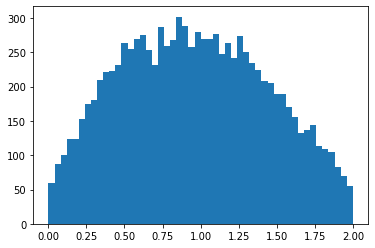

In [23]:
plt.hist(new_y[:,0],bins=50);

In [24]:
KSG = mg.revised_mi(x.reshape((*x.shape,1)),transformed_y,)
KSG

(0.7160580578530346, -7.5540157315807015)

In [25]:
MI.Mixed_KSG(x,transformed_y)/np.log(2)

0.7512980605523548

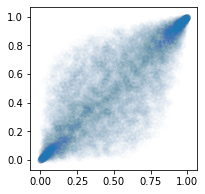

In [26]:
plt.figure(figsize=(3,3))
plt.scatter(*transformed_y[:,[0,1]].T,alpha=0.01)

(array([ 916., 1029., 1067.,  994., 1077., 1006., 1015.,  988.,  983.,
         925.]),
 array([2.33333333e-04, 1.00191667e-01, 2.00150000e-01, 3.00108333e-01,
        4.00066667e-01, 5.00025000e-01, 5.99983333e-01, 6.99941667e-01,
        7.99900000e-01, 8.99858333e-01, 9.99816667e-01]),
 <a list of 10 Patch objects>)

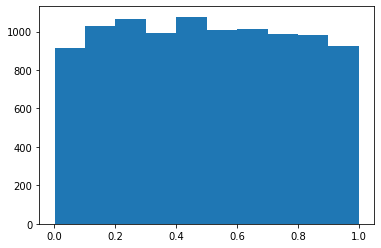

In [27]:
plt.hist(transformed_y[:,0])

In [33]:
N = Nvar
#redirect logging here
exp_pref='benchmark'
data_layers = [torch.tensor(transformed_y).clamp(0.001,0.999).float().to(device)]
copula_layers = []
for m in range(0,N-1):
    out_dir = f'{conf.path2outputs}/{exp_pref}/layer{m}'
    copulas, layer = [], []
    for n in range(1,N-m):
        print(m,n+m)
        samples = data_layers[-1][...,[n,0]]
#         waic, model = bvcopula.infer([bvcopula.GaussianCopula_Likelihood(),
#                                         bvcopula.ClaytonCopula_Likelihood(rotation='180°')],
#                                      train_x,samples,device=device)
        (likelihoods, waic) = select_copula.select_with_heuristics(x,samples.cpu().numpy(),device,exp_pref,out_dir,m,n+m,
                                                                  train_x=train_x, train_y=samples)
        weights_file = f"{out_dir}/model_{exp_pref}_{m}-{m+n}.pth"
        model = utils.get_model(weights_file, likelihoods, device) 
        with torch.no_grad():
            f = model(train_x).mean
            copula = model.likelihood.get_copula(f)
            copulas.append(copula)
            layer.append(copula.ccdf(samples))
    data_layers.append(torch.stack(layer,dim=-1))
    copula_layers.append(copulas)

NameError: name 'transformed_y' is not defined

In [28]:
vine_trained = CVine(copula_layers,train_x,device=device)
with open(f"{home}vine.pkl","wb") as f:
    pkl.dump([y,vine_trained],f)

In [40]:
subvine = vine_trained.create_subvine(torch.arange(0,NSamp,10))
%time CopulaGP = subvine.stimMI(sem_tol=0.01)

CopulaGP

CPU times: user 180 ms, sys: 688 ms, total: 867 ms
Wall time: 834 ms


(tensor([0.1393], device='cuda:1'),
 tensor(0.0126, device='cuda:1'),
 tensor([1.0676], device='cuda:1'),
 tensor(0.0088, device='cuda:1'))

In [4]:
with open(f"{home}vine.pkl","rb") as f:
    [y0,vine_trained] = pkl.load(f)

In [31]:
likelihoods = [bvcopula.GaussianCopula_Likelihood(),bvcopula.ClaytonCopula_Likelihood(rotation='180°')]
exp_pref='benchmark'
out_dir = f'{conf.path2outputs}/{exp_pref}/layer1'
weights_file = f"{out_dir}/model_{exp_pref}_{1}-{2}.pth"
model = utils.get_model(weights_file, likelihoods, device) 

In [20]:
MI.train_MINE(y,H=200,lr=0.01)

array(0.75959915, dtype=float32)

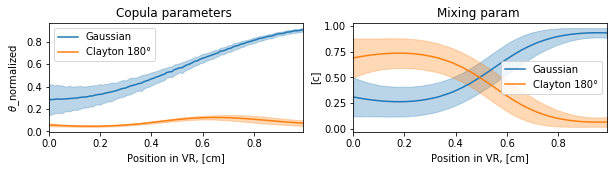

In [32]:
fig, ax = plt.subplots(1,2,figsize=(10,2))
utils.Plot_MixModel_Param_MCMC(ax,model,train_x[::100],x[::100],rho=None,title='',particles=200)

In [14]:
results_file = f"{home}/MI_gaussH_dump.pkl"
with open(results_file,'rb') as f:
    results = pkl.load(f)
results[0]

[[2, 10000],
 [0.20709936320781708, 0.007637974806129932],
 [0.16416442394256592,
  0.20821209415880843,
  0.2145851085138889,
  [0.1889289613655755,
   0.1877542123710257,
   0.20794921065509694,
   0.21860342838689115]],
 [array([[0.7983334 , 0.28622043],
         [0.12293912, 0.7117614 ],
         [0.917714  , 0.2309351 ],
         ...,
         [0.9288854 , 0.9302469 ],
         [0.4929661 , 0.49409306],
         [0.6297818 , 0.6297818 ]], dtype=float32), array([[0.6871 , 0.38245],
         [0.18525, 0.5247 ],
         [0.7431 , 0.33805],
         ...,
         [0.9656 , 0.966  ],
         [0.5119 , 0.51275],
         [0.67695, 0.6769 ]])]]

In [15]:
with open(results_file,'wb') as f:
    pkl.dump(results[:-7],f)

In [16]:
results0 = results

In [17]:
Ns = np.array([res[0][0] for res in results])
Ns

array([2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6,
       6, 6, 6, 7, 7, 7, 8, 8])

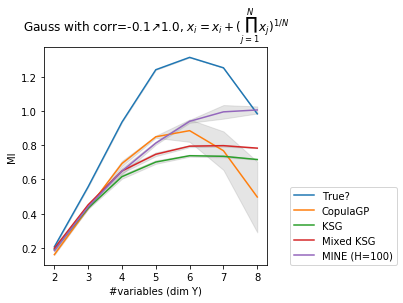

In [19]:
plt.figure(figsize=(4,4))
def line(H,label,cut=Ns.max()):
    NN = cut+1-Ns.min()
    A = np.empty((3,NN))
    for i in range(NN):
        n = Ns.min()+i
        A[0,i] = n
        A[1,i] = H[Ns==n].mean()
        A[2,i] = H[Ns==n].std()
    plt.plot(A[0],A[1],label=label)
    plt.fill_between(A[0],A[1]-A[2],A[1]+A[2],color='grey',alpha=0.2)
line(np.array([res[1][0] for res in results]),"True?")
for i,label in enumerate(["CopulaGP","KSG","Mixed KSG"]):
    line(np.array([res[2][i] for res in results]),label)
line(np.array([res[2][3][1] for res in results]),"MINE (H=100)")
# for i,H in enumerate([50,100,200,500]):
#     line(np.array([res[2][3][i] for res in results])/np.log(2),f"MINE (H={H})")
# plt.title("Gauss with corr=-0.1↗1.0, $x_i = x_i + \prod_{j=1}^{N} x_j$")
plt.title("Gauss with corr=-0.1↗1.0, $x_i = x_i + (\prod_{j=1}^{N} x_j)^{1/N}$")
plt.xlabel("#variables (dim Y)")
plt.ylabel("MI")
plt.legend(loc=(1.1,0));